In [ ]:
!pip install brian2
!pip install numpy matplotlib scipy statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.0 MB/s eta 0:00:00


In [ ]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import time
from google.colab import drive
import scipy.io as sio
import pandas as pd
import statsmodels.api as sm
from scipy.stats import t
from statsmodels.graphics.gofplots import qqplot

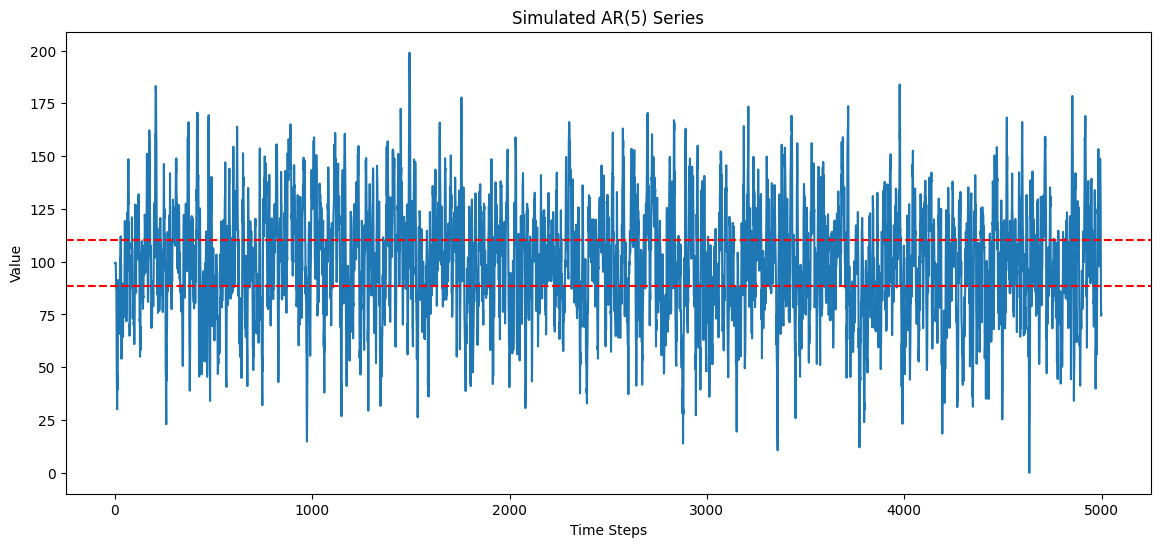

In [ ]:
# Number of time steps
n_steps = 5000

# AR(5) coefficients - example values (you should define these based on your model specifics)
coeffs = np.array([0.8, 0.4, -0.3, -0.2, 0.1])

# Initialize the series, starting with zeros or small random values for simplicity
np.random.seed(42)  # for reproducibility
series = np.zeros(n_steps)
series[:5] = np.random.normal(scale=0.1, size=5)

# Generate white noise (error terms)
noise = np.random.normal(scale=5.0, size=n_steps)

# Generate the AR(5) series
for i in range(5, n_steps):
    series[i] = (coeffs[0] * series[i-1] +
                 coeffs[1] * series[i-2] +
                 coeffs[2] * series[i-3] +
                 coeffs[3] * series[i-4] +
                 coeffs[4] * series[i-5] +
                 noise[i])

std = np.sqrt(1/(1 - np.sum(coeffs**2)))


temp = (series - np.min(series))/(np.max(series) - np.min(series))*199

std = std/(np.max(series) - np.min(series))*100

# Example use of the generated series
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(temp)
plt.axhline(y=1.96*std + np.mean(temp), color='r', linestyle='--', label='Horizontal Line at y = 3')  # Draw a horizontal line
plt.axhline(y=-1.96*std + np.mean(temp), color='r', linestyle='--', label='Horizontal Line at y = 3')  # Draw a horizontal line
plt.title('Simulated AR(5) Series')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.show()

## Code below for trying the Madrid Detrended data



Mounted at /content/drive/


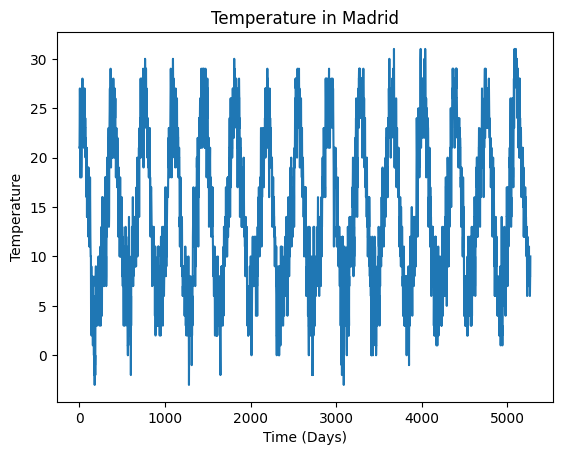

In [ ]:
drive.mount('/content/drive/')
from scipy.optimize import curve_fit
data=pd.read_csv('/content/drive/MyDrive/ColabNotebooks/MIT/MatrixMethods/madrid.csv')
temp_dat = data['Mean TemperatureC']
temp_dat = np.array(list(temp_dat[1541:]))
plt.figure(0)
plt.plot(temp_dat)
plt.xlabel("Time (Days)")
plt.ylabel("Temperature")
plt.title("Temperature in Madrid")
plt.show()

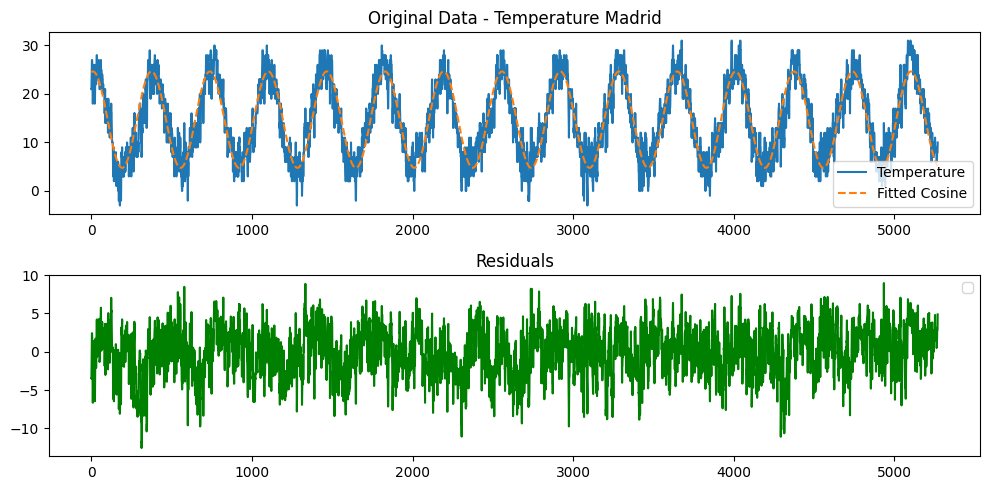

In [ ]:
def cosine(t, A, omega, phi, offset):
    return A * np.cos(omega * t + phi) + offset



t = np.arange(0, len(temp_dat), 1)

initial_guess = [20, 2 * np.pi * 1/365, 0, 0]




params, params_covariance = curve_fit(cosine, t, temp_dat, p0=initial_guess)

fitted_cosine = cosine(t, *params)

# Calculate residuals
residuals = temp_dat - fitted_cosine



# Plotting the results
plt.figure(figsize=(10, 5))
plt.subplot(211)
plt.title("Original Data - Temperature Madrid")
plt.plot(t, temp_dat, label='Temperature')
plt.plot(t, fitted_cosine, label='Fitted Cosine', linestyle='--')
plt.legend()


plt.subplot(212)
plt.title("Residuals")
plt.plot(t, residuals, color='green')
plt.legend()

plt.tight_layout()
plt.show()

temp = (residuals - np.min(residuals))/(np.max(residuals) - np.min(residuals))*199

## Dividing into training and testing

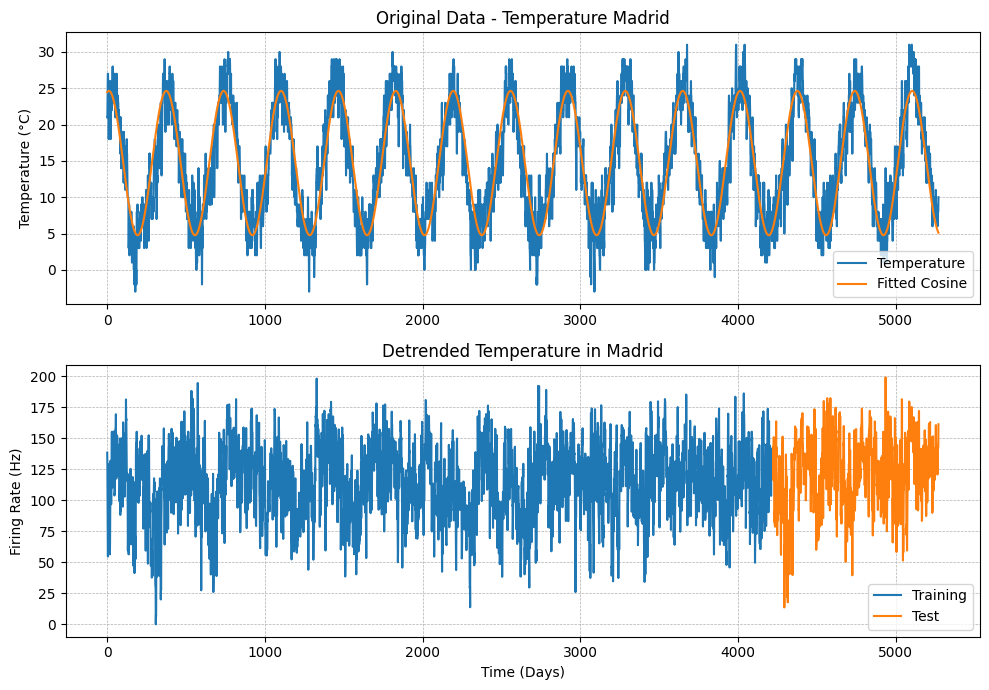

In [ ]:
t_steps = 5
t = np.linspace(0,len(temp)-1, len(temp))
i80 = int(len(t)*0.8)
train = temp[:i80]
test = temp[i80:]
x_train = [train[i:i+t_steps] for i in range(len(train) -t_steps)]
y_train = train[t_steps:]
x_test = [test[i:i+t_steps] for i in range(len(test) - t_steps)]
y_test = test[t_steps:]
y_bin_train = np.floor(y_train/20).astype(int)
y_bin_test = np.floor(y_test/20).astype(int)




#print(temp[:10])
#print(x_train[0], y_bin_train[0])
#print(set(y_bin_train))
#print(set(y_bin_test))
# Plotting the results
plt.figure(figsize=(10, 7))
plt.subplot(211)
plt.title("Original Data - Temperature Madrid")
plt.plot(t, temp_dat, label='Temperature')
plt.plot(t, fitted_cosine, label='Fitted Cosine')
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)


plt.subplot(212)
plt.plot(t[:i80-t_steps], y_train, label="Training")
plt.plot(t[i80+t_steps:], y_test, label="Test")
plt.xlabel("Time (Days)")
plt.ylabel("Firing Rate (Hz)")
plt.title("Detrended Temperature in Madrid")
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)


plt.tight_layout()
plt.show()
mat = np.array(x_train)
from sklearn.decomposition import PCA

## Try another binning:

In [ ]:
# Calculate quantiles for 10 bins (0%, 10%, 20%, ..., 100%)
quantiles = np.percentile(y_train, np.linspace(0, 100, 11))

# Use np.digitize to bin data according to these quantiles
bins = np.digitize(y_train, quantiles)

# To ensure data in each bin is treated inclusively on the upper bound:
# Adjusting bins so that the last data point falls into the last bin (bin index 10, not 11)
bins = np.where(bins > 10, 10, bins)

# Print out how many data points fall into each bin (for verification)
print("Bin counts:")
for i in range(1, 11):
    print(f"Bin {i}: {np.sum(bins == i)}")

# Optionally, printing the edges used for each bin:
print("Quantile edges:")
for i in range(len(quantiles)):
    print(f"{i*10}%: {quantiles[i]}")

print(bins[:10])
print(y_train[:10])

Bin counts:
Bin 1: 421
Bin 2: 421
Bin 3: 421
Bin 4: 421
Bin 5: 421
Bin 6: 421
Bin 7: 421
Bin 8: 421
Bin 9: 421
Bin 10: 422
Quantile edges:
0%: 0.0
10%: 75.7263988979045
20%: 89.29495307551312
30%: 99.23360600166116
40%: 108.14973853681649
50%: 116.47072183884562
60%: 124.33044997644916
70%: 131.6815118191653
80%: 140.243356842486
90%: 150.45544792992763
100%: 198.05090549032087
[8 7 4 1 1 1 1 1 3 7]
[138.36474843 128.97450335 101.11371848  54.78242783  54.72317702
  54.69132674  73.18474928  73.2077204   91.75595881 128.82944948]


## PCA

[0.71735733 0.15930319]


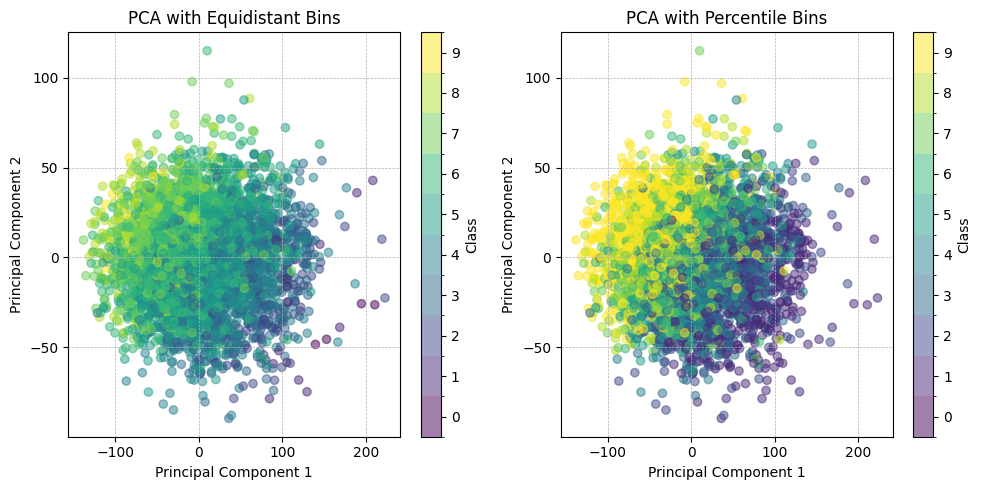

In [ ]:
from matplotlib.colors import ListedColormap, BoundaryNorm
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(mat)

components = pca.components_
explained_variance_ratio = pca.explained_variance_ratio_
print(explained_variance_ratio)



n_classes = np.unique(y_bin_train).size  # Number of unique classes in y_bin_train
cmap = ListedColormap(plt.cm.viridis(np.linspace(0, 1, n_classes)))

# Create a norm with boundaries at the middle points between classes
boundaries = np.arange(-0.5, n_classes + 0.5, 1)
norm = BoundaryNorm(boundaries, cmap.N, clip=True)

n_classes2 = np.unique(bins).size  # Number of unique classes in y_bin_train
cmap2 = ListedColormap(plt.cm.viridis(np.linspace(0, 1, n_classes2)))

# Create a norm with boundaries at the middle points between classes
boundaries2 = np.arange(-0.5, n_classes2 + 0.5, 1)
norm2 = BoundaryNorm(boundaries2, cmap.N, clip=True)


plt.figure(figsize=(10, 5))
plt.subplot(121)

# Plotting the principal components
scatter = plt.scatter(principalComponents[:, 0], principalComponents[:, 1], c=y_bin_train, cmap=cmap, norm=norm, alpha=0.5)
plt.colorbar(scatter, ticks=np.arange(n_classes), label='Class')  # Show colorbar with integer ticks
plt.title('PCA with Equidistant Bins')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, linestyle='--', linewidth=0.5)


plt.subplot(122)
scatter2 = plt.scatter(principalComponents[:, 0], principalComponents[:, 1], c=bins, cmap=cmap2, norm=norm2, alpha=0.5)
plt.colorbar(scatter2, ticks=np.arange(n_classes2), label='Class')  # Show colorbar with integer ticks
plt.title('PCA with Percentile Bins')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


## Parameters

In [ ]:
n_input = 5 # input layer (one neuron per image pixel)
n_e = 500 # excitatory neurons
n_i = n_e # inhibitory neurons

# ---------------------------- Constants for init_excit() ---------------------------------

# Excitatory neuron parameters for leaky integrate-and-fire model
v_rest_e = -60.*mV # resting membrane potential
v_reset_e = -65.*mV # resting membrane potential
v_thresh_e = -52.*mV # resting membrane threshold                 -52  lowered
v_init_e = v_rest_e - 20.*mV # initial membrane potential

# Equilibrium potentials
E_inh_e = -100.*mV
E_exc_e = 0*mV

# Time constants
tau_e = 100 * ms
tau_ge_e = 5*ms
tau_gi_e = 10*ms

# ---------------------------- Constants for init_inhib() ------------------------------

# Inhibitory neuron parameters for leaky integrate-and-fire model
v_rest_i = -60.*mV # resting membrane potential
v_reset_i = -45.*mV # resting membrane potential
v_thresh_i = -40.*mV # resting membrane threshold
v_init_i = v_rest_i - 20.*mV # initial membrane potential

# Equilibrium potentials
E_inh_i = -85.*mV
E_exc_i = 0*mV

# Time constants
tau_i = 10 * ms
tau_ge_i = 5*ms
tau_gi_i = 2.0*ms

# --------------------------- Constants for stdp ------------------------------

taupre = taupost = 30*ms
gmax = 1
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax


In [ ]:
class SNN():
    def __init__(self, neurons):
        self.model = {}
        # model is a dictionary containing the names of and the compartments
        # in the neuron network.

        # Each input is a Poisson spike-train
        self.model['INPUT'] = PoissonGroup(n_input, rates=np.zeros(n_input)*Hz, name='INPUT')

        self.model['EXCITE'] = self.init_excit()
        self.model['INHIB'] = self.init_inhib()
        self.model['C1'] = self.conn_input_excit(self.model['INPUT'], self.model['EXCITE'])

        (C2, C3) = self.conn_inhib_excit(self.model['EXCITE'], self.model['INHIB'])
        self.model['C2'] =C2
        self.model['C3'] =C3

        # array of indices of neurons for monitoring
        self.neurons = neurons
        print('snn',self.neurons)

        # monitors = self.init_monitors(self.model)

        self.net = Network(list(self.model.values()))
        self.net.run(0*second)

    def get(self, val):

      return self.net[val]


    # Let students fill out the functions***************
    def init_excit(self):
        '''
        Initializes and returns the group of excitatory neurons using NeuronGroup()

        Read through section 2.1 for equations and
        1-intro-to-brian-neurons for usage on NeuronGroup()

        All needed parameters are given
        '''

        refrac_e = 5.*ms # Excitatory neuron refractory period

        neuron_e = '''
            dv/dt = (ge*(E_exc_e-v) + gi*(E_inh_e-v) + (v_rest_e-v)) / tau_e : volt
            dge/dt = -ge / tau_ge_e : 1
            dgi/dt = -gi / tau_gi_e : 1
            '''

        E = NeuronGroup(n_e, neuron_e, threshold='v>v_thresh_e', refractory=refrac_e, reset='v=v_reset_e', method='euler', name='EXCITE')
        E.v = v_init_e

        return E


    def init_inhib(self):

        '''
        Initializes and returns the group of inhibitory neurons.

        Analogous to init_excit()
        '''

        refrac_i = 2.*ms # Inhibitory neuron refractory period

        neuron_i = '''
            dv/dt = (ge*(E_exc_i-v) + (v_rest_i-v)) / tau_i : volt
            dge/dt = -ge / tau_ge_i : 1
            '''

        I = NeuronGroup(n_i, neuron_i, threshold='v>v_thresh_i', refractory=refrac_i, reset='v=v_reset_i', method='euler', name='INHIB')
        I.v = v_init_i

        return I


    def conn_input_excit(self, I, E):
        '''

        Arguments:
        I: input layer
        E: excitatory layer

        Initializes and returns the group of first-to-second layer synaptic connections of
        one-to-all connections between input and excitatory neurons.

        Use Synapses() for initialization, read through 2-intro-to-brian-synapses for usage on Synapses().

        All synapses from input neurons to excitatory neurons are
        learned using STDP.

        Follow usage of STDP model in end of 2-intro-to-brian-synapses
        and https://brian2.readthedocs.io/en/stable/examples/synapses.STDP.html.
        '''

        # Note addition of lr variable s.t
        # lr = 1 to enable stdp
        # lr = 0 to disable (weight unable to change)
        stdp='''w : 1
            lr : 1 (shared)
            dApre/dt = -Apre / taupre : 1 (event-driven)
            dApost/dt = -Apost / taupost : 1 (event-driven)'''
        pre='''ge += w
            Apre += dApre
            w = clip(w + lr*Apost, 0, gmax)'''
        post='''Apost += dApost
            w = clip(w + lr*Apre, 0, gmax)'''

        C1 = Synapses(I, E, stdp, on_pre=pre, on_post=post, method='euler', name='C1')
        C1.connect()
        C1.w = 'rand()*gmax' # random weights initialization
        C1.lr = 1

        return C1

    def conn_inhib_excit(self, E, I):
        '''
        Initializes and returns the group of second layer synaptic connections consisting of:
            - One-to-one connections between excitatory and inhibitory neurons
            - One-to-all except for the one from which it receives a connection between inhibitory and excitatory neurons

        Description of Network Architecture in section 2.2.

        Returns the two synapse connections as a tuple (E->I, I->E)
        '''

        # excitatory neurons -> inhibitory neurons
        C2 = Synapses(E, I, 'w : 1', on_pre='ge += w', name='C2')
        C2.connect(j='i')
        C2.delay = 'rand()*10*ms'
        C2.w = 3 # strong weight to ensure an excitatory neuron will trigger a spike in its corresponding inhibitory neuron

        # inhibitory neurons -> excitatory neurons
        C3 = Synapses(I, E, 'w : 1', on_pre='gi += w', name='C3')
        C3.connect(condition='i!=j')
        C3.delay = 'rand()*5*ms'
        C3.w = 0.04#.03

        return (C2, C3)

    def init_monitors(self, M):
        '''
        Initializes Brian2 monitors for graphing purposes

        Arguments:
        M: model of network containing neurons and synapses

        Adds a list of monitors including
            - Spike monitor for excitatory neurons
            - Spike monitor for inhibitory neurons
            - State monitor for excitatory neurons recording membrane voltage (v)
            - State monitor for inhibitory neurons recording membrane voltage (v)
            - State monitor for variables used in STDP (w, Apre, Apost)

        Descriptions and usage of Brian's SpikeMonitor() and StateMonitor() can be viewed
        at [1-intro-to-brian-neurons](https://brian2.readthedocs.io/en/stable/resources/tutorials/1-intro-to-brian-neurons.html)

        '''


        spikemonE = SpikeMonitor(M['EXCITE'], name='SM_E', record=True)
        # spikemonE = SpikeMonitor(M['EXCITE'][self.neurons_e], name='SM_E')
        # print('mon',self.neurons_e)
        spikemonI = SpikeMonitor(M['INHIB'], name='SM_I', record=True)
        # spikemonI = SpikeMonitor(M['INHIB'][self.neurons_e], name='SM_I')


        # Record membrane voltage for the two neuron groups
        volE = StateMonitor(M['EXCITE'], 'v', name='V_E', record=self.neurons)
        volI = StateMonitor(M['INHIB'], 'v', name='V_I', record=self.neurons)    # not needed changed to False

        # We record the input layer neuron connected to the center pixel of the 28x28 images: source 392
        # C1 connection from input layer to excitatory layer
        #neurons = np.random.randint(100, size=4)        # placed outside neurons ro track

        # This one is interesting to change
        stdp_mon = StateMonitor(M['C1'], ['w', 'Apre', 'Apost'], record=M['C1'][2, neurons], name='SM_STDP')

        self.net.add([spikemonE, spikemonI, volE, volI, stdp_mon])

    def train(self, X):
        '''
        Trains the model on a set of training images

        Arguments:
        X: List of training image data from dataset

        Follow the instructions for training in section 2.5 and 2.6
        '''
        self.net['C1'].lr = 1 # enable stdp

        print('... starting training ...')

        for count, img in enumerate(X[:-5]):
            # Present image to the network's input layer for 350 ms
            self.net['INPUT'].rates = img.ravel()*Hz
            self.net.run(0.35*second)

            # Leave the network 150 ms without any input
            self.net['INPUT'].rates = np.zeros(n_input)*Hz
            self.net.run(0.15*second)
            if np.mod(count,100) == 0:
              print(count)

        # construct monitors to store relevant network data
        # we start monitoring only until we have 15 images left in X to save memory
        self.init_monitors(self.net)

        for count, img in enumerate(X[-5:]):
            # Present image to the network's input layer for 350 ms
            self.net['INPUT'].rates = img.ravel()*Hz
            self.net.run(0.35*second)

            # Leave the network 150 ms without any input
            self.net['INPUT'].rates = np.zeros(n_input)*Hz
            self.net.run(0.15*second)
            # print(counter)

    def evaluate(self, X, test=False):
        '''
        Evaluates the model after training is done

        Arguments:
        X: List of image data from dataset

        Follow the instructions for evaluation in section 2.5 and 2.6

        Returns:
        Spikes per neuron for each image
        '''
        self.net['C1'].lr = 0  # disable stdp

        if test:
            SM_EVAL = SpikeMonitor(self.net['EXCITE'], name='SM_EVAL')
            self.net.add(SM_EVAL)
        else:
            # Remove monitors used for training
            self.net.remove(self.net['SM_E'])
            self.net.remove(self.net['SM_I'])
            self.net.remove(self.net['V_E'])
            self.net.remove(self.net['V_I'])
            self.net.remove(self.net['SM_STDP'])

        # Spikes per neuron for each image
        spikes = []
        print(".... starting presentation/labeling phase ...")

        for count, img in enumerate(X):
            # Spike monitor to count number of excitatory neuron spikes for current image
            sm = SpikeMonitor(self.net['EXCITE'], name='MON')
            self.net.add(sm)

            # Present image to the network's input layer for 350 ms
            self.net['INPUT'].rates = img.ravel()*Hz
            self.net.run(0.35*second)

            # Add spikes per neuron for current image
            spikes.append(np.array(sm.count, dtype=int8))

            # Leave the network 150 ms without any input
            self.net['INPUT'].rates = np.zeros(n_input)*Hz
            self.net.run(0.15*second)

            # Remove monitor after presenting image (otherwise counts would accumulate)
            self.net.remove(self.net['MON'])
            if np.mod(count,100) == 0:
              print(count)

        return spikes

In [ ]:
def plot_spikes(SM_E, SM_I=None, last_s=10):
  '''
  Arguments:
  SM_E: Voltages of excitatory neurons over course of training
  SM_I: Voltages of inhibitory neurons over course of training
  last_s: number of seconds to plot from end of training session

  Plots time given index of neuron for each spike
  '''
  plt.figure(figsize=(10, 3), dpi=80)

  e_e = SM_E.t[-1]/second
  idx = [i for i, v in enumerate(SM_E.t/second) if e_e - last_s <= v <= e_e]
  t_e = SM_E.t[idx]
  s_e = SM_E.i[idx]

  if SM_I:
    e_i = SM_I.t[-1]/second
    idx = [i for i, v in enumerate(SM_I.t/second) if e_i - last_s <= v <= e_i]
    t_i = SM_I.t[idx]
    s_i = SM_I.i[idx]

  plt.plot(t_e/ms, s_e, '.b', label='Excitatory')
  if SM_I:
    plt.plot(t_i/ms, s_i, '.r', label='Inhibitory')
  plt.xlabel('Time (ms)')
  plt.ylabel('Neuron index')
  plt.legend()
  plt.show()

def plot_vols(V_E, V_I, neurons):
  '''
  Arguments:
  V_E: Voltages of excitatory neurons over course of training
  V_I: Voltages of inhibitory neurons over course of training
  neurons: list of indices of excitatory and inhibitory neuron focused on

  Plots Time vs. Membrane voltage
  '''

  for i, n in enumerate(neurons):
    plt.figure(figsize=(10, 3), dpi=80)
    plt.plot(V_E.t/ms, V_E.v[i]/mV, 'r', label='Excitatory')
    plt.plot(V_I.t/ms, V_I.v[i]/mV, 'b', label='Inhibitory')

    # Add horizontal bars to represent voltage thresholds for the two types of neurons
    plt.axhline(v_thresh_e/mV, color='green', label='v_thresh_e')
    plt.axhline(v_thresh_i/mV, color='black', label='v_thresh_i')

    plt.legend()
    plt.xlabel('Time (ms)')
    plt.ylabel('Membrane Voltage')
    plt.title('Neuron ' + str(n))
    plt.show()

def plot_final_weights(weights, neuron=0):
  '''
  Arguments:
  weights: final weights of synaptic connections between input and excitatory neurons after stdp learning
  neuron: index of excitatory neuron to focus on

  Plots weights of each input layer neuron to a specific excitatory neuron as a image (2D regular raster)
  '''
  plt.figure(figsize=(10, 3), dpi=80)

  # Reshape weights to same dimensions as an image from the dataset
  w = np.reshape(weights[:, :5], (5, n_input))

  plt.imshow(w, aspect='auto')
  plt.colorbar()
  plt.title('Final Weights of Connections from Input Layer to Excitatory Neurons')
  plt.ylabel("Exititory neurons")
  plt.xlabel("Input neurons")
  plt.yticks([0,1,2,3,4],['250', '251','252','253','254'])
  plt.show()

def plot_stdp_vars(SM_STDP, neurons):
  '''
  Arguments:
  SM_STDP: Monitor containing values of STDP variables (w, Apre, Apost) over time
  neurons: list of indices of excitatory and inhibitory neuron focused on

  Return plot of SM_STDP
  '''
  plt.figure(figsize=(10, 7), dpi=80)

  plt.subplot(311)
  for i, n in enumerate(neurons):
    plt.plot(SM_STDP.t/ms, SM_STDP.w[i].T/gmax, label='E. ' + str(n))
  plt.legend()
  plt.ylabel('w/gmax')
  plt.title('Weights from Input layer neuron 3')

  plt.subplot(312)
  for i, n in enumerate(neurons):
    plt.plot(SM_STDP.t/ms, SM_STDP.Apre[i].T, label='E. ' + str(n))
  plt.legend()
  plt.ylabel('Apre')

  plt.subplot(313)
  for i, n in enumerate(neurons):
    plt.plot(SM_STDP.t/ms, SM_STDP.Apost[i].T, label='E. ' + str(n))
  plt.legend()
  plt.ylabel('Apost')
  plt.xlabel('Time (ms)')

  plt.show()

def visualize(network, neurons):
    '''
    Visualize network during training using plots of connected Brian monitors
    '''
    plot_stdp_vars(network.get('SM_STDP'), neurons)
    plot_final_weights(network.get('C1').w)
    #r = np.random.randint(n_e, size=5)    #**************
    plot_vols(network.get('V_E'), network.get('V_I'), neurons)
    plot_spikes(network.get('SM_E'), network.get('SM_I'))

def plot_spikes_for(network, y_pred, y_true, I, n=5):
  '''
  Arguments:
    network
    y_pred: Predicted values returned by classifier
    y_true: Ground truth (correct) target values
    I: array of images
    n: number of images in test data to plot

    Plots time given index of neuron for each spike, for n images
  '''

  plt.figure(figsize=(n,n))

  # plot last n images in the training set with labels
  for i in range(1, n+1):
    plt.subplot(1, n, i)
    plt.imshow(I[-i], cmap=plt.get_cmap('gray'))
    plt.title('Pred: ' + str(y_pred[-i]))
    plt.axis('off')

  plt.show()

  # We use 0.5*n for last_s since each image is presented for 0.5 seconds (0.35 + 0.15)
  plot_spikes(network.get('SM_EVAL'), last_s=(0.5*n))


In [ ]:
def pre_test(neurons, train_items=20):
  '''
  function used to test the learning on a small training set (10) and visualize the output.
  '''
  seed()

  network = SNN(neurons)
  network.train(x_train[:train_items])
  return network

#neurons = np.random.randint(n_e, size=4)  # neurons to track
neurons = np.arange(int(n_e/2),int(n_e/2)+5)
print(neurons)
network = pre_test(neurons)

[250 251 252 253 254]
snn [250 251 252 253 254]
... starting training ...
0


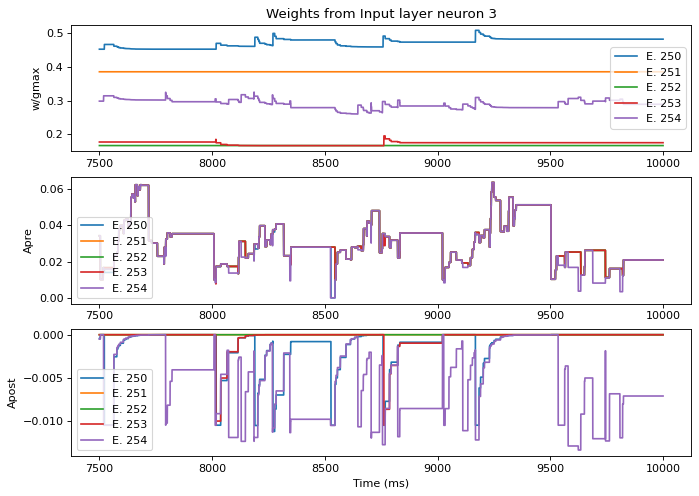

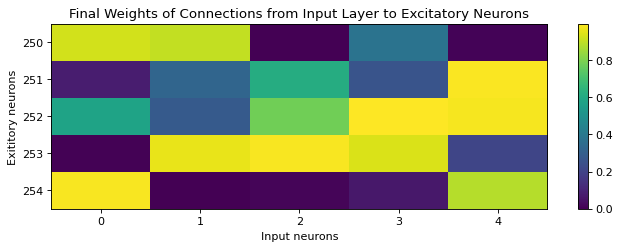

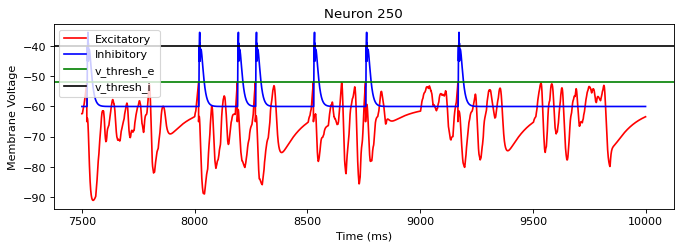

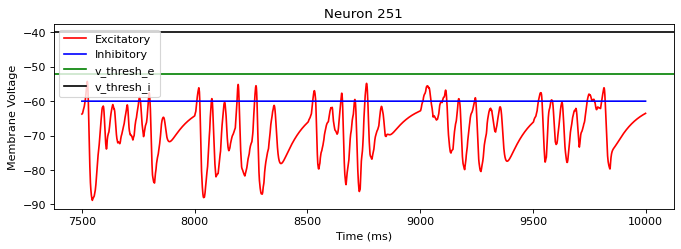

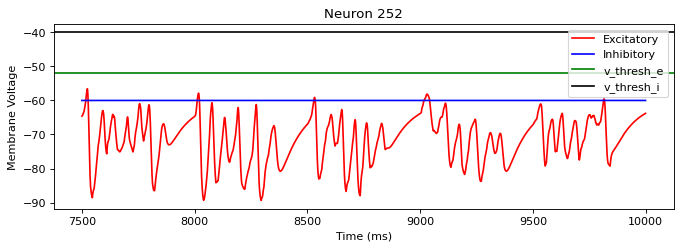

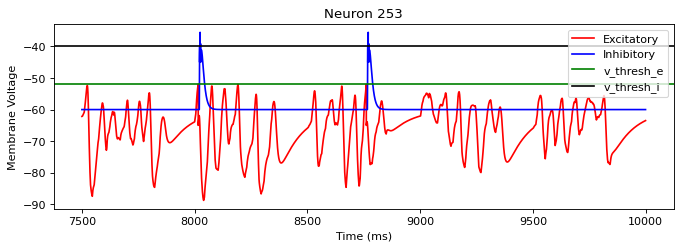

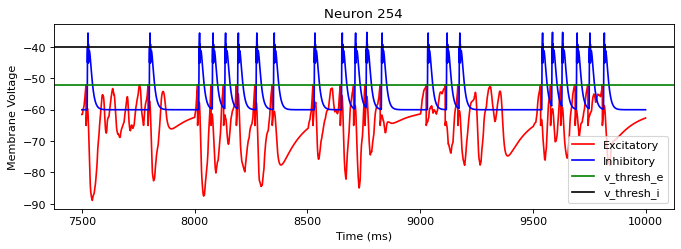

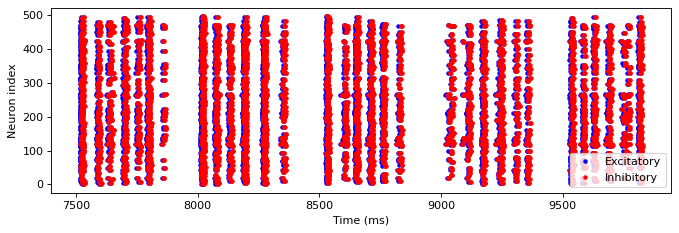

In [ ]:
visualize(network, neurons)

In [ ]:
def predict(classes, f_train, labels, f_test):                 # work on this
    '''
    Arguments:
    f_train: Spikes per neuron for each image over one presentation of the training set
    labels: labels assigned to each image for f_train
    f_test: Spikes per neuron for each image over one presentation of the test set

    Follow section 2.6 for steps on classifying
    '''

    # print('f_train: ', f_train)
    # print('labels: ', labels)

    label_to_class = { 0 : 0, 5 : 1, 9 : 2 }
    class_to_label = {0 : 0, 1 : 5, 2 : 9}

    # counts[i] is the number of labels for class i in the training set
    _, counts = np.unique(labels, return_counts=True)

    # neuron_response[i][j] is the total number of spikes neuron j has for class i
    neuron_response = np.zeros((classes, 2))
    for i, img in enumerate(f_train):
        for j, spikes in enumerate(img):
            # neuron_response[label_to_class[labels[i]]][j] += spikes
            neuron_response[labels[i]][j] += spikes

    print('neuron_response: ', neuron_response)

    # neuron_response_norm is neuron_response normalized by the number of labels for each class in the training set
    neuron_response_norm = []
    for i in range(classes):
        neuron_response_norm.append(np.divide(neuron_response[i], counts[i]))

    print('label_count: ', counts)
    print('neuron_response_norm: ', neuron_response_norm)

    # neuron_class[i] is the class associated to neuron i
    neuron_class = np.argmax(neuron_response_norm, axis=0)
    print('neuron_class: ', neuron_class)

    # counts[i] is the number of neurons associated to class i
    _, counts = np.unique(neuron_class, return_counts=True)

    # classify[i] is the predicted digit for image i in the test set
    classify = []
    for img in f_test:

        # class_response[i] is the total number of neuron spikes associated with class i
        class_response = np.zeros(classes)
        for j, spikes in enumerate(img):
           class_response[neuron_class[j]] += spikes

        # class_response_norm[i] is the average neuron spikes for class i
        class_response_norm = np.divide(class_response, counts)

        # Choose the class with the highest average firing rate
        # classify.append(class_to_label[np.argmax(class_response)])
        classify.append(np.argmax(class_response))

    print('classification: ', classify)

    return classify

# main function to run full simulation
def test(neurons_e, train=2000, present=2000, classify=1000):     #  **************************************************
    '''
    Arguments:
    train: number of images to train network on
    present: number of images to present network on with labels after training
    classify: number of images to test network on for classification
    '''
    seed()

    print('creating network...')

    network = SNN(neurons_e)
    # Feed training set to network with STDP on
    print('feeding training set to network...')
    network.train(x_train[:train])

    #visualize(network,neurons_e)

    # Store the state of the network and all included objects in train.b2
    # Can later be restored using network.net.restore()
    network.net.store('SNN_trained', 'SNN_trained.b2')

    # Freeze STDP and feed training set to network again to collect spikes w/ converged weights
    print('presenting labels to network...')
    f_train = network.evaluate(x_train[:present])

    # Feed test set to network to collect spikes for use w/ classifier
    print('feeding test set to network...')
    f_test = network.evaluate(x_test[:classify], test=True)


    # loop through all estimators for max depth of random forest trees
    # to determine which results in the best accuracy
    # n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
    # results = []

    # for e in n_estimators:

    # Create Random Forest for use in classifying
    clf = RandomForestClassifier(max_depth=20)           # check this one

    return clf, f_test, f_train, network
    # Fit/train RandomForest of top of features with true training labels provided


    # plt.plot(n_estimators, results)

#neurons_e = np.random.randint(n_e, size=4)  # neurons to track
neurons_e = np.arange(int(n_e/2),int(n_e/2)+5)
clf, f_test, f_train, network = test(neurons_e, 500, 500, 500)

#t_end = time.perf_counter()

#print('... it took ....',t_end - t0)

creating network...
snn [250 251 252 253 254]
feeding training set to network...
... starting training ...
0
100
200
300
400
presenting labels to network...
.... starting presentation/labeling phase ...
0
100
200
300
400
feeding test set to network...
.... starting presentation/labeling phase ...
0
100
200
300
400


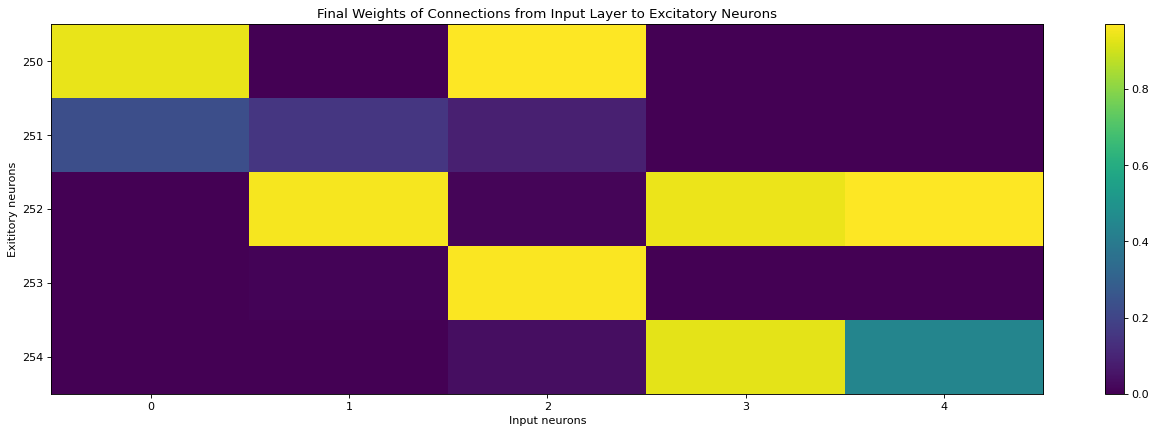

KeyError: 'No object with name "SM_E" found'

In [ ]:
#visualize(network,neurons_e)
#plot_stdp_vars(network.get('SM_STDP'), neurons)
plot_final_weights(network.get('C1').w)
#r = np.random.randint(n_e, size=5)    #**************
#plot_vols(network.get('V_E'), network.get('V_I'), neurons)
plot_spikes(network.get('SM_E'), network.get('SM_I'))

confusion_matrix:  [[ 0  0  0  0  1  1  0  1  0  0]
 [ 0  0  0  1  0  5  6  0  0  0]
 [ 0  0  1  0  0 18  6  5  0  0]
 [ 0  0  0  0  3 15 11  7  0  0]
 [ 0  0  1  1  8 29 23 16  0  0]
 [ 0  1  1  6 18 44 46 19  0  0]
 [ 0  3  3  6  8 46 45 14  0  0]
 [ 0  1  4  3  9 29 18  8  0  0]
 [ 0  0  0  0  1  3  2  2  0  0]
 [ 0  0  0  0  0  1  0  0  0  0]]
truths:  [6 6 5 2 2 2 3 3 4 6 6 5 4 3 4 4 3 2 3 4 5 6 5 5 5 4 5 5 6 7 7 5 5 5 5 6 7
 6 6 6 7 7 7 7 6 6 5 5 5 5 6 6 7 7 7 8 7 7 5 6 6 6 6 7 7 7 6 6 6 7 6 6 6 6
 6 6 7 6 4 5 6 7 5 4 5 4 4 5 5 5 5 6 7 7 7 7 6 5 5 4 5 8 7 5 6 6 7 7 6 5 5
 6 7 6 5 5 6 7 8 9 8 8 7 6 6 5 5 5 5 6 4 2 3 4 5 4 2 5 3 3 3 4 5 5 5 5 5 4
 6 4 5 4 3 5 4 4 5 5 5 4 4 4 5 4 3 4 2 2 2 4 4 5 4 2 3 3 3 3 3 3 2 4 6 7 6
 7 7 7 6 4 5 6 5 4 4 6 6 4 4 4 6 5 6 5 5 7 7 5 6 6 6 7 6 7 5 5 5 6 7 6 6 6
 6 6 6 6 6 5 5 3 4 4 5 4 6 6 6 5 5 5 4 6 5 4 2 4 4 5 5 4 5 5 6 6 5 4 4 4 2
 5 5 6 6 7 6 7 5 4 4 3 4 4 4 4 4 2 2 2 3 3 3 3 2 1 2 2 2 2 1 2 4 4 4 5 4 5
 5 5 5 5 5 4 5 4 2 1 1 1 0 0 0 2 2 1 1 2 

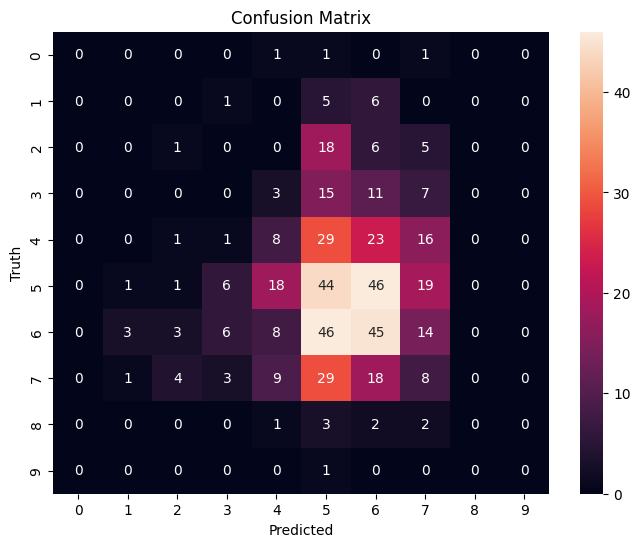

In [ ]:
present = 500
classify = 500
train = 500
#clf.fit(f_train, y_bin_train[:present])
def fit_to_labels(bin):
  clf.fit(f_train, bin[:present])

    # Use RandomForest to predict labels with test set
  predictions = clf.predict(f_test)

  cm = confusion_matrix(bin[:classify], predictions)
  print('confusion_matrix: ', cm)
  print('truths: ', bin[:classify])
  print('predictions: ', predictions)
  print('Percentage of correct answers:%.2f'%(100*np.trace(cm)/np.sum(cm)))
  import seaborn as sn
  plt.figure(figsize=(8,6))
  sn.heatmap(cm ,annot=True , fmt = 'd')
  plt.title("Confusion Matrix")
  plt.xlabel('Predicted')
  plt.ylabel('Truth')
  #rforest.score(xtest,y_test)

      # Calculate accuracy score by comparing w/ true test labels
  accuracy = (bin[:classify] == predictions).sum() / classify
  print(accuracy)
  return predictions

#predictions = fit_to_labels(y_bin_train)
predictions = fit_to_labels(y_bin_train)



#plot_spikes_for(network, predictions, y_bin_test[:classify], x_test[:classify], 20)

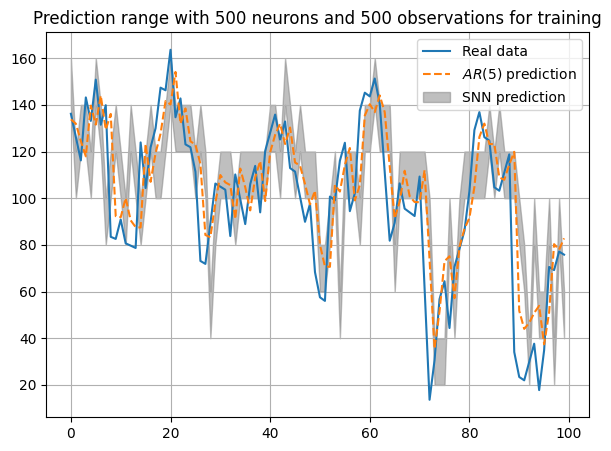

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# List with numbers 0 to 9

len_plot = 100
k = 0

lower_bound = predictions[k:k+len_plot] *20
upper_bound = (predictions[k:k+len_plot] + 1) *20

#predicted_lower_limits = np.array([quantiles[p-1] if p > 0 else quantiles[0] for p in predictions[:len_plot]])
#predicted_upper_limits = np.array([quantiles[p] for p in predictions[:len_plot]])
#print(lower_limits)


model = sm.tsa.ARIMA(y_train, order=(5,0,0))
fitted_model = model.fit()
params = fitted_model.params[1:-1][::-1]
#print(fitted_model.summary())

ar_pred = np.zeros(len(x_test))
i = 0
mn = np.mean(x_test)
for i in range(len(x_test)):
  ar_pred[i] = np.dot((x_test[i] - mn), params) + mn



plt.figure(figsize=(7,5))
plt.plot(y_test[k:k+len_plot], label="Real data")
plt.plot(ar_pred[k:k+len_plot], label="$AR(5)$ prediction", linestyle='--')
plt.fill_between(range(len_plot), lower_bound, upper_bound, color='gray', alpha=0.5, label="SNN prediction")
#plt.fill_between(range(len_plot), predicted_lower_limits, predicted_upper_limits, color='gray', alpha=0.5)
plt.grid(True)
plt.legend()
plt.title(f"Prediction range with {n_e} neurons and {train} observations for training")

plt.show()


## Mean square error

Predictions with 500 neurons, 500 observations, 1 maximum weight
Drifted: 726.745337433638
Mean: 740.5558471912096
AR: 412.5665933663829
MSE self: 1430.4033102941746


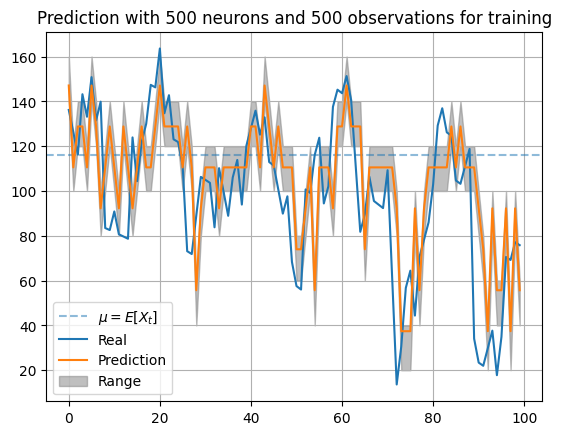

In [ ]:
#lower_bound = predicted_lower_limits
#upper_bound = predicted_upper_limits

mean_bucket = (upper_bound + lower_bound)/2
p_bucket = (np.mean(temp) - mean_bucket)/2/np.mean(temp)
bucket_list = (0.5 + p_bucket)*upper_bound + (0.5 - p_bucket)*lower_bound
#bucket_list = (predicted_upper_limits + predicted_lower_limits)/2
MSE_nn = 1/len_plot*sum((y_test[:len_plot] - bucket_list)**2)
MSE_nn2 = 1/len_plot*sum((y_test[:len_plot] - mean_bucket)**2)

#print(p_bucket)
m = np.mean(temp)
MSE_ar = 1/len_plot*sum((y_test[:len_plot] - ar_pred[:len_plot])**2)
MSE_self = 1/(len_plot)*sum((y_test[:len_plot] - m)**2)
print(f"Predictions with {n_e} neurons, {train} observations, {gmax} maximum weight")
print(f'Drifted: {MSE_nn}')
print(f'Mean: {MSE_nn2}')
print(f'AR: {MSE_ar}')
print(f'MSE self: {MSE_self}')
plt.figure(11)
plt.axhline(y = m, alpha=0.5, linestyle="--", label="$\mu = E[X_t]$")
plt.plot(y_test[:len_plot], label="Real")
#plt.plot(ar_pred[:len_plot])
#plt.fill_between(range(len_plot), lower_bound, upper_bound, color='gray', alpha=0.5)
plt.plot(bucket_list[:len_plot], label="Prediction")
#plt.plot(ar_pred[:len_plot], label="$AR(5)$ prediction", linestyle='--')
plt.fill_between(range(len_plot), lower_bound, upper_bound, color='gray', alpha=0.5, label="Range")
#plt.plot(mean_bucket[:len_plot], label="Mean")
plt.title(f"Prediction with {n_e} neurons and {train} observations for training")
plt.legend()
plt.grid(True)
plt.show()

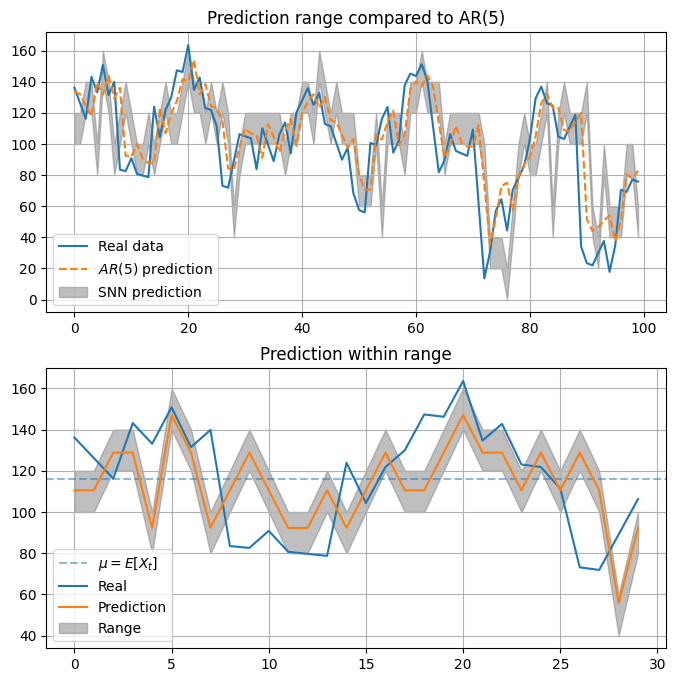

In [ ]:
len_plot=100

plt.figure(figsize=(8,8))

plt.subplot(211)
plt.plot(y_test[k:k+len_plot], label="Real data")
plt.plot(ar_pred[k:k+len_plot], label="$AR(5)$ prediction", linestyle='--')
plt.fill_between(range(len_plot), lower_bound, upper_bound, color='gray', alpha=0.5, label="SNN prediction")
#plt.fill_between(range(len_plot), predicted_lower_limits, predicted_upper_limits, color='gray', alpha=0.5)
plt.grid(True)
plt.title(f"Prediction range compared to AR(5)")
plt.legend()


len_plot1 = 30
plt.subplot(212)
plt.axhline(y = m, alpha=0.5, linestyle="--", label="$\mu = E[X_t]$")
plt.plot(y_test[:len_plot1], label="Real")
#plt.plot(ar_pred[:len_plot])
#plt.fill_between(range(len_plot), lower_bound, upper_bound, color='gray', alpha=0.5)
plt.title(f"Prediction within range")
plt.plot(bucket_list[:len_plot1], label="Prediction")
#plt.plot(ar_pred[:len_plot], label="$AR(5)$ prediction", linestyle='--')
plt.fill_between(range(len_plot1), lower_bound[:len_plot1], upper_bound[:len_plot1], color='gray', alpha=0.5, label="Range")
#plt.plot(mean_bucket[:len_plot], label="Mean")
#plt.title(f"Prediction with {n_e} neurons and {train} observations for training")
plt.legend()
plt.grid(True)
plt.show()

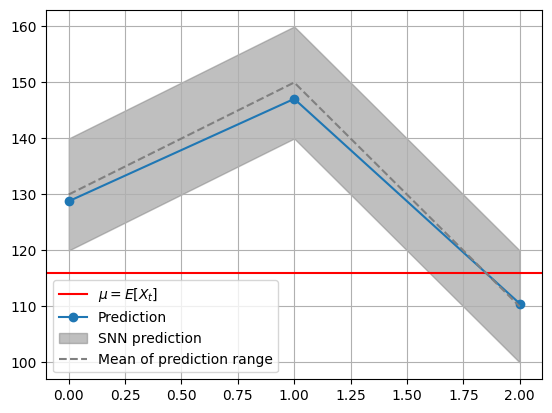

In [ ]:
plt.figure(12)
val = 7
#plt.plot(y_test[:len_plot], label="Real")
#plt.plot(ar_pred[:len_plot])
#plt.fill_between(range(len_plot), lower_bound, upper_bound, color='gray', alpha=0.5)
plt.axhline(y = m, color = "red", label="$\mu = E[X_t]$")
plt.plot(bucket_list[val:val+3], label="Prediction", marker='o')
plt.fill_between(range(3), lower_bound[val:val+3], upper_bound[val:val+3], color='gray', alpha=0.5, label="SNN prediction")
plt.plot(mean_bucket[val:val+3], label="Mean of prediction range", linestyle = "--", color="gray")
#plt.plot(mean_bucket[:len_plot], label="Mean")
plt.legend()
plt.grid(True)
plt.show()